In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
import gc
import random
from hierarchical_transformer_model_v2 import HierarchicalTransformer

In [2]:
def initial_cleanup():
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()
    
    # Set random seeds
    random.seed(69)
    np.random.seed(69)
    torch.manual_seed(69)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(69)
        torch.cuda.manual_seed_all(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print("Clean slate initialized!")

# Call this at the top of your notebook
initial_cleanup()

Clean slate initialized!


In [3]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import os

In [ ]:
def create_transformer_ready_arrays(data_dir: str = "data/keypoints", 
                                  percentile_cutoff: float = 95.0):
    """
    Create numpy arrays ready for transformer training with proper masking
    
    Returns:
        X: Input sequences [batch_size, max_seq_len, num_keypoints, coordinates]
        y: Labels [batch_size]
        attention_masks: Attention masks [batch_size, max_seq_len]
        sequence_lengths: Original sequence lengths [batch_size]
    """
    labels = {"squats": 0, "deadlifts": 1, "shoulder_press": 2}
    temp_samples = []
    sequence_lengths = []
    
    # Load all samples
    for exercise, label in labels.items():
        folder_path = os.path.join(data_dir, exercise)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist")
            continue
            
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                path = os.path.join(folder_path, file)
                try:
                    sample = np.load(path)
                    temp_samples.append((sample, label))
                    sequence_lengths.append(sample.shape[0])
                    print(f"Loaded {file} from {exercise} with shape {sample.shape}")
                except Exception as e:
                    print(f"Error loading {path}: {e}")
    
    if not temp_samples:
        raise ValueError("No samples loaded!")
    
    # Determine max_frames using percentile to avoid extreme outliers
    max_frames = int(np.percentile(sequence_lengths, percentile_cutoff))
    print(f"Using max_frames = {max_frames} ({percentile_cutoff}th percentile)")
    print(f"Sequence length stats - Min: {min(sequence_lengths)}, Max: {max(sequence_lengths)}")
    
    # Filter out sequences that are too long
    filtered_samples = []
    filtered_lengths = []
    for i, (sample, label) in enumerate(temp_samples):
        if sequence_lengths[i] <= max_frames:
            filtered_samples.append((sample, label))
            filtered_lengths.append(sequence_lengths[i])
        else:
            print(f"Filtering out sample with length {sequence_lengths[i]}")
    
    print(f"Kept {len(filtered_samples)} out of {len(temp_samples)} samples")
    
    # Create padded arrays with attention masks
    X = []
    y = []
    attention_masks = []
    final_sequence_lengths = []
    
    for sample, label in filtered_samples:
        seq_len = sample.shape[0]
        
        # Pad sequence
        if seq_len < max_frames:
            pad_len = max_frames - seq_len
            pad = np.zeros((pad_len, sample.shape[1], sample.shape[2]))
            padded_sample = np.concatenate([sample, pad], axis=0)
        else:
            padded_sample = sample
        
        # Create attention mask
        attention_mask = np.zeros(max_frames)
        attention_mask[:seq_len] = 1
        
        X.append(padded_sample)
        y.append(label)
        attention_masks.append(attention_mask)
        final_sequence_lengths.append(seq_len)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    attention_masks = np.array(attention_masks)
    final_sequence_lengths = np.array(final_sequence_lengths)
    
    print(f"Final dataset shape:")
    print(f"X: {X.shape}")
    print(f"y: {y.shape}")
    print(f"attention_masks: {attention_masks.shape}")
    print(f"sequence_lengths: {final_sequence_lengths.shape}")
    
    print(f"Kept {len(filtered_samples)} out of {len(temp_samples)} samples")
    num_filtered_out = len(temp_samples) - len(filtered_samples)
    print(f"Number of samples filtered out due to length: {num_filtered_out}") # Add this line
    
    return X, y, attention_masks, final_sequence_lengths

In [5]:
X_np, y_np, attention_masks_np, sequence_lengths_np = create_transformer_ready_arrays()

Loaded squats_0.npy from squats with shape (85, 33, 4)
Loaded squats_1.npy from squats with shape (85, 33, 4)
Loaded squats_10.npy from squats with shape (71, 33, 4)
Loaded squats_100.npy from squats with shape (97, 33, 4)
Loaded squats_101.npy from squats with shape (97, 33, 4)
Loaded squats_102.npy from squats with shape (195, 33, 4)
Loaded squats_103.npy from squats with shape (195, 33, 4)
Loaded squats_104.npy from squats with shape (236, 33, 4)
Loaded squats_105.npy from squats with shape (236, 33, 4)
Loaded squats_106.npy from squats with shape (109, 33, 4)
Loaded squats_107.npy from squats with shape (109, 33, 4)
Loaded squats_108.npy from squats with shape (112, 33, 4)
Loaded squats_109.npy from squats with shape (112, 33, 4)
Loaded squats_11.npy from squats with shape (71, 33, 4)
Loaded squats_110.npy from squats with shape (123, 33, 4)
Loaded squats_111.npy from squats with shape (123, 33, 4)
Loaded squats_112.npy from squats with shape (96, 33, 4)
Loaded squats_113.npy from 

In [6]:
# Convert to PyTorch tensors
X_np = X_np[:, :, :, :3]  # drop visibility
X_tensor = torch.from_numpy(X_np).float() # Assuming keypoints are floats
y_tensor = torch.from_numpy(y_np).long()  # Labels should be long for CrossEntropyLoss
attention_masks_tensor = torch.from_numpy(attention_masks_np).float()


X_temp, X_test, y_temp, y_test, mask_temp, mask_test = train_test_split(
    X_tensor, y_tensor, attention_masks_tensor, 
    test_size=0.1, random_state=69
)

val_ratio = 0.1 / 0.9  # ≈ 0.1111 of remaining
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_temp, y_temp, mask_temp, 
    test_size=val_ratio, random_state=69
)

# Create dataloaders with temporal masks included
train_dataset = TensorDataset(X_train, y_train, mask_train)
val_dataset = TensorDataset(X_val, y_val, mask_val)
test_dataset = TensorDataset(X_test, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
torch.unique(y_tensor)

tensor([0, 1, 2])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HierarchicalTransformer(
    num_joints=33,
    num_frames=200,
    d_model=64,
    nhead=4,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=3,
    dim_feedforward=512,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
num_epochs = 30
train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0

    for X_batch, y_batch, mask_batch in train_loader:
        # print("DEBUG: DataLoader mask_batch shape:", mask_batch.shape)
        # print("Initial y_batch shape:", y_batch.shape)
        # print("Initial y_batch content (first 5):", y_batch[:5])
        # print("Initial y_batch dtype:", y_batch.dtype)
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x=X_batch, temporal_mask=mask_batch)
        # print("DEBUG: ")
        # print("Output: ", outputs.shape)
        # print("Y: ", y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

     # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            outputs = model(x=X_batch, temporal_mask=mask_batch)
            loss = criterion(outputs, y_batch)
            
            

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/30 | Train Loss: 1.0569, Acc: 0.4129 | Val Loss: 1.0106, Acc: 0.4151
Epoch 2/30 | Train Loss: 0.9610, Acc: 0.5711 | Val Loss: 0.8800, Acc: 0.7453
Epoch 3/30 | Train Loss: 0.8185, Acc: 0.7737 | Val Loss: 0.7368, Acc: 0.8019
Epoch 4/30 | Train Loss: 0.6937, Acc: 0.8584 | Val Loss: 0.5824, Acc: 0.9104
Epoch 5/30 | Train Loss: 0.5895, Acc: 0.8809 | Val Loss: 0.4694, Acc: 0.9340
Epoch 6/30 | Train Loss: 0.5082, Acc: 0.9040 | Val Loss: 0.3960, Acc: 0.9292
Epoch 7/30 | Train Loss: 0.4370, Acc: 0.9159 | Val Loss: 0.3315, Acc: 0.9387
Epoch 8/30 | Train Loss: 0.3794, Acc: 0.9200 | Val Loss: 0.2831, Acc: 0.9340
Epoch 9/30 | Train Loss: 0.3383, Acc: 0.9159 | Val Loss: 0.2624, Acc: 0.9387
Epoch 10/30 | Train Loss: 0.3126, Acc: 0.9171 | Val Loss: 0.2307, Acc: 0.9292
Epoch 11/30 | Train Loss: 0.2863, Acc: 0.9194 | Val Loss: 0.2210, Acc: 0.9245
Epoch 12/30 | Train Loss: 0.2718, Acc: 0.9218 | Val Loss: 0.2034, Acc: 0.9198
Epoch 13/30 | Train Loss: 0.2600, Acc: 0.9254 | Val Loss: 0.2069, Acc: 0.

In [10]:
from sklearn.metrics import classification_report

# Switch to eval mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch, mask_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        # If your model uses the mask in forward()
        outputs = model(X_batch, mask_batch)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', 'shoulder_press'])
print(report)

                precision    recall  f1-score   support

        squats       0.92      0.97      0.94        86
     deadlifts       0.96      0.98      0.97        55
shoulder_press       0.97      0.90      0.93        71

      accuracy                           0.95       212
     macro avg       0.95      0.95      0.95       212
  weighted avg       0.95      0.95      0.95       212



In [11]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(all_labels, all_preds)
print(matrix)

[[83  1  2]
 [ 1 54  0]
 [ 6  1 64]]


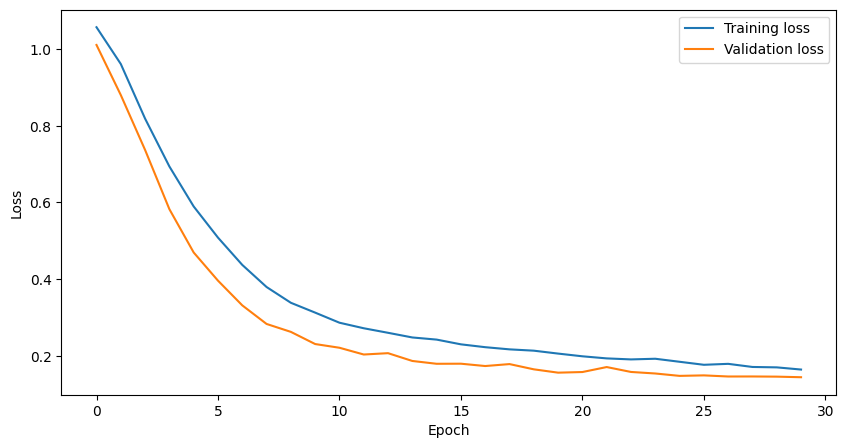

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

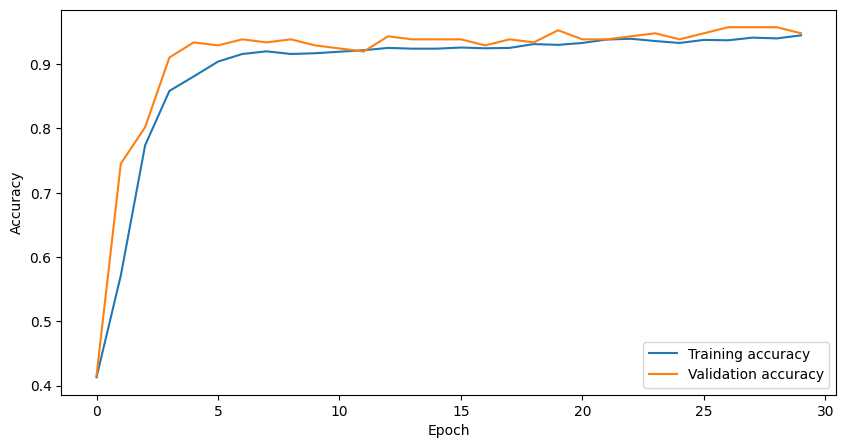

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training accuracy')
plt.plot(val_acc_history, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# Save model to disk
torch.save(model.state_dict(), 'models/hierarchical transformer/hierarchical_transformer_v2_weights_2025-06-21.pth')